In [1]:
import torch
import torch.nn as nn

import torch.optim as optim
from itertools import chain

from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from torchsummary import summary
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

import numpy as np
from sklearn.manifold import TSNE

/home/kirsr/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# В этой части лабораторной работы вам предстоит спроектировать, реализовать и обучить вариационный автокодировщик для генерации рукописных цифр.
# Сценарий выполнения кода:
# 1. Обучение автокодировщика.
# 2. Отображение проекции скрытого пространства на плоскость для визуальной оценки распределения данных в скрытом пространстве.
# 3. Интерполяция между несколькими точками в скрытом пространстве, декодирование промежуточных точек в исходное пространство
# и анимация результата.
# 4. Генерация нескольких изображений цифр.
class Encoder(nn.Module):
    # Класс кодировщика, нужно реализовать.

    def __init__(self, latent_size):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, latent_size)
        self.fc5 = nn.Linear(128, latent_size)
        # ============

        self.latent_size = latent_size

    def forward(self, x):
        mu = None  # модельное математическое ожидание z, нужно вычислить.
        log_var = None  # модельный логарифм дисперсии z, нужно вычислить.
        # ВАШ КОД ЗДЕСЬ
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # x = self.fc4(x) 
        # mu = torch.mean(x, 1, True)
        # log_var = torch.std(x, 1, True).log()
        mu = self.fc4(x)
        log_var = torch.exp(self.fc5(x))
        # ============
        return mu, log_var

    def sample_latent(self, x):
        # Метод для выборки z при помощи кодировщика.
        mu, log_var = self(x)
        return torch.randn_like(mu).to(device) * torch.exp(0.5 * log_var) + mu, mu, log_var


class Decoder(nn.Module):
    # Класс декодировщика, нужно реализовать.

    def __init__(self, latent_size):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 784)
        # ============

        self.latent_size = latent_size

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x) 
        # ============
        return x


def train_ae(data_loader, encoder, decoder, epochs, lr, device):
    # Функция для обучения автокодировщика.
    # Принимает на вход загрузчик тренеровочных данных,
    # кодировщик, декодировщик, количество эпох для обучения, скорость обучения и устройство,
    # на котором находится автокодировщик (cpu или cuda).

    print('Обучение автокодировщика..')

    encoder.train()
    decoder.train()

    recon_loss_func =  nn.MSELoss() # Функция потерь восстановления, нужно выбрать.
    kl_loss_func = None  # Функция потерь похожести распределения на нормальное.
    optimizer = torch.optim.AdamW(chain(encoder.parameters(), decoder.parameters()))  # Оптимизатор, нужно выбрать и настроить.
    loss_history = list()

    for epoch in range(epochs):
        for i, (batch, _) in enumerate(data_loader):
            # ВАШ КОД ЗДЕСЬ
            batch = batch.to(device)
            optimizer.zero_grad()
            mu, log_var = encoder(batch)
            mu, log_var = mu.to(device), log_var.to(device)
            # z = encoder.sample_latent(batch)[0].to(device)
            z = mu + log_var * torch.distributions.Normal(0, 1).sample(mu.shape).to(device)
            # kl_loss = (-0.5*(1+log_var - mu**2- torch.exp(log_var)).sum(dim = 1)).mean(dim =0)
            kl_loss = 1/2 * (torch.exp(log_var) - log_var - 1).mean()
            reconstructed = decoder(z).reshape(-1, 1, 28, 28)
            recon_loss = recon_loss_func(batch, reconstructed)
            
            loss = recon_loss + kl_loss * lr 
            loss.backward()
            optimizer.step()
            # ============
            if i % 100 == 0:
                print('Потери восстановления:', recon_loss.item())
                print('Потери расхождения распределений:', kl_loss.item())
            loss_history.append(loss.log().item())
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

    encoder.eval()
    decoder.eval()

    print('Готово!')

    plt.plot(loss_history)
    plt.show()

def lerp(v1, v2, t):
    # Функция для линейной интерполяции между двумя векторами.
    return v1 * (1 - t) + v2 * t


def get_frame(i, data):
    # Функция для анимации
    i = min(i, len(data) - 1)
    ax.clear()
    ax.imshow(data[i])

In [3]:
LATENT_SIZE = 64  # размерность скрытого пространства, можно варьировать.

BATCH_SIZE = 256
EPOCHS = 15
LEARNING_RATE = 1e-3

ANIMATION_IMAGES = 5
ANIMATION_N_FRAMES = (ANIMATION_IMAGES - 1) * 20
ANIMATION_INTERVAL = 50

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
encoder = Encoder(LATENT_SIZE).to(device)
decoder = Decoder(LATENT_SIZE).to(device)

summary(encoder, [[1, 28, 28]])
summary(decoder, [[LATENT_SIZE]])

train_data = MNIST('data', train=True, download=True, transform=ToTensor())
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 256]         131,328
            Linear-3                  [-1, 128]          32,896
            Linear-4                   [-1, 64]           8,256
            Linear-5                   [-1, 64]           8,256
Total params: 582,656
Trainable params: 582,656
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.22
Estimated Total Size (MB): 2.23
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           8,320
            Linear-2                  [-1

Обучение автокодировщика..
Потери восстановления: 0.12572269141674042
Потери расхождения распределений: 0.37097713351249695
Потери восстановления: 0.03517265245318413
Потери расхождения распределений: 0.0003252204624004662
Потери восстановления: 0.024209685623645782
Потери расхождения распределений: 8.422878454439342e-05
Эпоха 1 / 15. Потери на последнем пакете: 0.02232990227639675
Потери восстановления: 0.022176468744874
Потери расхождения распределений: 0.00012930110096931458
Потери восстановления: 0.0185544453561306
Потери расхождения распределений: 4.144306149100885e-05
Потери восстановления: 0.015946995466947556
Потери расхождения распределений: 1.6818707081256434e-05
Эпоха 2 / 15. Потери на последнем пакете: 0.014998172409832478
Потери восстановления: 0.016243847087025642
Потери расхождения распределений: 1.0863115676329471e-05
Потери восстановления: 0.015137399546802044
Потери расхождения распределений: 2.9328550226637162e-05
Потери восстановления: 0.014526160433888435
Потери ра

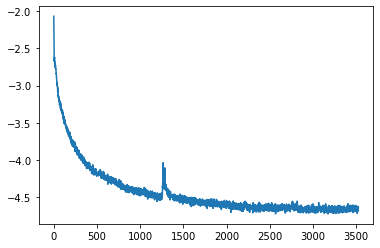

In [5]:
train_ae(train_data_loader, encoder, decoder, EPOCHS, LEARNING_RATE, device)

test_imgs = list()
for batch, target in train_data_loader:
    test_imgs.extend(zip(batch, target))
    if len(test_imgs) > 5000:
        break
imgs_list, targets = zip(*test_imgs)
imgs = torch.stack(imgs_list).to(device)

Проецирование скрытого пространства на плоскость..


/home/kirsr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kirsr/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


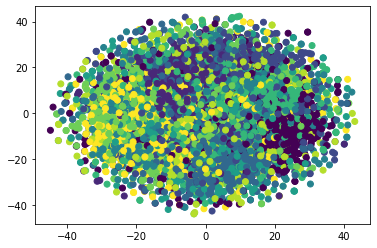

Готово!


In [6]:
print('Проецирование скрытого пространства на плоскость..')
tsne = TSNE()
latent_imgs_emb = [encoder.sample_latent(img.unsqueeze(0))[0].cpu().detach()[0].numpy() for img in imgs]
latent_imgs_emb = tsne.fit_transform(np.array(latent_imgs_emb))
x, y = zip(*latent_imgs_emb)
plt.scatter(x, y, c=targets)
plt.show()
print('Готово!')

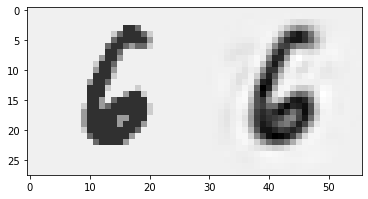

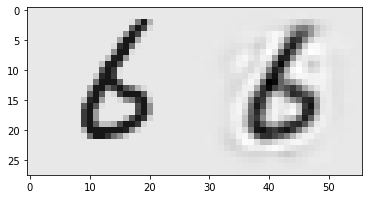

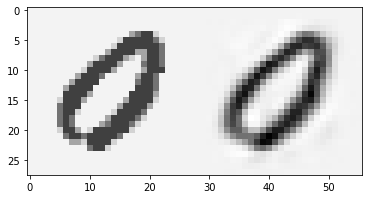

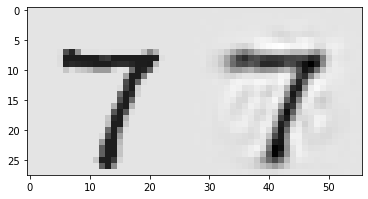

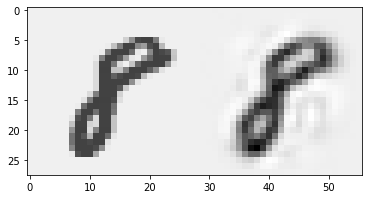

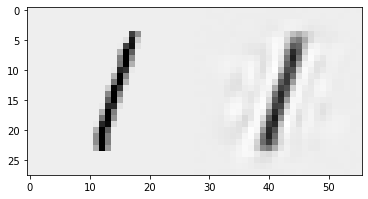

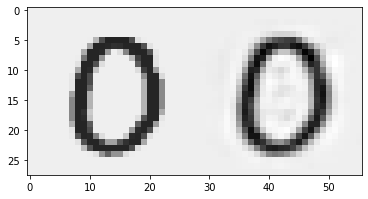

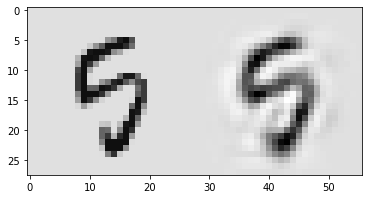

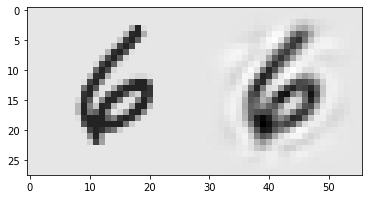

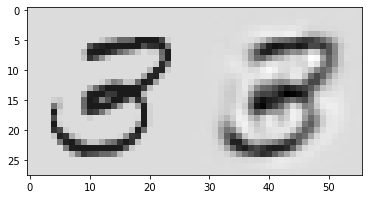

In [7]:
latent_imgs = encoder(imgs)[0]
restored_imgs = decoder(latent_imgs).reshape(-1, 1, 28, 28)

for i in range(10):
    orig_restored = torch.hstack((imgs[i][0], restored_imgs[i][0].detach()))
    plt.imshow(orig_restored.cpu().numpy(), cmap='Greys')
    plt.show()

Рассчет анимации..
Готово!


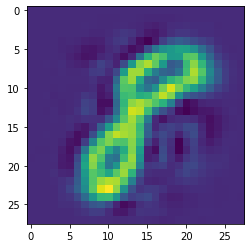

In [8]:
print('Рассчет анимации..')
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
animation_data = list()
for i in range(4 * 20):
    frames_per_conn = ANIMATION_N_FRAMES // (ANIMATION_IMAGES - 1)
    vec_index = i // frames_per_conn
    t = i % frames_per_conn / frames_per_conn
    interp_vec = lerp(latent_imgs[vec_index], latent_imgs[vec_index + 1], t)
    restored_img = decoder(interp_vec.unsqueeze(0))
    animation_data.append(restored_img.reshape( 28, 28).detach().cpu().numpy())
print('Готово!')

animation = FuncAnimation(figure, get_frame, frames=ANIMATION_N_FRAMES, interval=ANIMATION_INTERVAL, fargs=(animation_data,))
from IPython.display import HTML
HTML(animation.to_jshtml())